In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm


import traceback
import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
#from torch.optim import LBFGS


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST: ACC = 0.733152

In [4]:
folder="data/FOREX_cadjpy-day-High"
x_col=["Bid_Open", "Bid_High", "Bid_Low", "Bid_Close", "Bid_Volume", "Ask_Open", "Ask_High", "Ask_Low", "Ask_Close","Ask_Volume"]
target_col=["class"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col

    #df_y[target_col] = df_y[target_col].astype(int)
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #print(X_train_full)
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [8]:
dtype = torch.get_default_dtype()

In [10]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1., start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
               metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
                val_metric = val_loss
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    val_metric = results[metric][-1]
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = epoch
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [27]:
def grid_search_kan(dataset, output_dim=1):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 9))
    lamb_options = [1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                
                print(f"Testing width=[{attributes}, {hidden}, {output_dim}], lamb={lamb}, grid={grid}")
                model = KAN(width=[attributes, hidden, output_dim], grid=grid, k=3, seed=381, device=device)
                
                def train_acc_kan():
                    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))
                
                def val_acc_kan():
                    return torch.mean((torch.round(model(dataset['val_input'])[:,0]) == dataset['val_label'][:,0]).type(dtype))

                # Custom training
                model_state, _, best_epoch = custom_fit(model, dataset, opt="LBFGS", steps=20, lamb=lamb, 
                                                        metrics=(train_acc_kan, val_acc_kan), display_metrics=['train_acc_kan', 'val_acc_kan'])
                model.load_state_dict(model_state)

                # Evaluate
                avg_acc = torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))
                print(avg_acc)
                # Save this model info
                top_models.append({
                    "acc_test": avg_acc,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    "state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })
                
                del model
                torch.cuda.empty_cache()
                gc.collect()

                # Keep only top 5
                top_models = sorted(top_models, key=lambda x: x["acc_test"], reverse=True)[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, {output_dim}], grid={cfg['grid']}, lamb={cfg['lamb']} | best_epoch={entry['best_epoch']} | acc_test={entry['acc_test']:.5f}")

    #return top_models

### Functions for CNN

In [12]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS", metrics=None, display_metrics=None):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}

    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())


        if display_metrics == None:
            pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [13]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [6, 5, 4]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

In [30]:
def grid_search_cnn(dataset, steps=110, opt='LBFGS', batch=-1):
    cnn_blocks_options = list(range(1, 4))
    dense_layers_options = list(range(1, 4))

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for cnn_blocks in cnn_blocks_options:
        for dense_layers in dense_layers_options:
            print(f"Testing cnn_blocks={cnn_blocks}, dense_layers={dense_layers}")
            model = build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape)
            def train_acc_cnn():
                return torch.mean((torch.round(model(0, dataset['train_img'])[:,0]) == dataset['train_label'][:,0]).type(dtype))
            
            def val_acc_cnn():
                return torch.mean((torch.round(model(0, dataset['val_img'])[:,0]) == dataset['val_label'][:,0]).type(dtype))
            # Custom training
            model_state, _, best_epoch = fit_cnn_only_model(model, dataset, steps=steps, opt=opt, batch=batch, 
                                                        metrics=(train_acc_cnn, val_acc_cnn), display_metrics=['train_acc_cnn', 'val_acc_cnn'])
            model.load_state_dict(model_state)

            # Evaluate
            avg_acc = torch.mean((torch.round(model(0, dataset['test_img'])[:,0]) == dataset['test_label'][:,0]).type(dtype))
            print(avg_acc)
            # Save this model info
            top_models.append({
                "acc_test": avg_acc,
                "config": {"cnn_blocks": cnn_blocks, "dense_layers": dense_layers},
                #"state_dict": copy.deepcopy(model_state),
                "best_epoch": best_epoch
            })
            
            del model
            torch.cuda.empty_cache()
            gc.collect()
            # Keep only top 5
            top_models = sorted(top_models, key=lambda x: x["acc_test"], reverse=True)[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. cnn_blocks={cfg['cnn_blocks']}, dense_layers={cfg['dense_layers']} | best_epoch={entry['best_epoch']} | acc={entry['acc_test']:.5f}")

    #return top_models

### Hybrid Functions

In [37]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}
    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_metric = 0
    val_metric = 0

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)

            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()


        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())


        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            string = ''
            data = ()
            for metric in display_metrics:
                val_metric = results[metric][-1]
                string += f' {metric}: %.2e |'
                try:
                    results[metric]
                except:
                    raise Exception(f'{metric} not recognized')
                data += (results[metric][-1],)
            pbar.set_description(string % data)

        if val_metric > best_metric:
            best_epoch = step
            best_metric = val_metric
            best_model_state = copy.deepcopy(model.state_dict())

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"✅ Best validation Accuracy: {best_metric:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [17]:
def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [18]:
def grid_search_kan_hybrid(dataset, model_class, max_steps=30):
    hidden_neuron_options = list(range(1, attributes // 2 + 1))
    grid_options = list(range(3, 9))
    lamb_options = [1e-02, 1e-03, 1e-04, 1e-05, 1e-06, 1e-07]

    top_models = []  # list of dicts: each will have 'loss', 'config', 'state_dict'

    for hidden in hidden_neuron_options:
        for grid in grid_options:
            for lamb in lamb_options:
                print(f"Testing {hidden} hidden neurons, lamb={lamb}, grid={grid}")
                model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=hidden, kan_grid=grid)  # Attempt to create Model3

                def train_acc_hybrid():
                    return torch.mean((torch.round(model(dataset['train_input'], dataset['train_img'])[:,0]) == dataset['train_label'][:,0]).type(dtype))
                
                def val_acc_hybrid():
                    return torch.mean((torch.round(model(dataset['val_input'], dataset['val_img'])[:,0]) == dataset['val_label'][:,0]).type(dtype))
                # Custom training
                model_state, _, best_epoch = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=max_steps, lamb=lamb,
                                                                   metrics=(train_acc_hybrid, val_acc_hybrid), display_metrics=['train_acc_hybrid', 'val_acc_hybrid'])
                model.load_state_dict(model_state)

                # Evaluate
                avg_acc = torch.mean((torch.round(model(dataset['test_input'], dataset['test_img'])[:,0]) == dataset['test_label'][:,0]).type(dtype))
                print(f'avg_acc {avg_acc}')
                # Save this model info
                top_models.append({
                    "avg_acc": avg_acc,
                    "config": {"hidden": hidden, "grid": grid, "lamb": lamb},
                    #"state_dict": copy.deepcopy(model_state),
                    "best_epoch": best_epoch
                })
                del model
                torch.cuda.empty_cache()
                gc.collect()
        # Keep only top 5
        top_models = sorted(top_models, key=lambda x: x["avg_acc"], reverse=True)[:5]

    print("\n✅ Top 5 Configurations:")
    for i, entry in enumerate(top_models):
        cfg = entry["config"]
        print(f"{i+1}. width=[{attributes}, {cfg['hidden']}, 1], grid={cfg['grid']}, lamb={cfg['lamb']}| best_epoch={entry['best_epoch']} | avg_acc={entry['avg_acc']:.5f}")


# Load Dataset and Images

In [19]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [20]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(num_columns))
print(image_size)

4


In [21]:
dataset_name = 'FOREX_cadjpy-day-High'
#Select the model and the parameters
problem_type = "supervised"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Classification/{dataset_name}/images_{dataset_name}_{name}"

In [22]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 4, 4)
Attributes:  10


In [23]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [24]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [25]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([1173, 10])
Train target shape: torch.Size([1173, 1])
Test data shape: torch.Size([367, 10])
Test target shape: torch.Size([367, 1])
Validation data shape: torch.Size([294, 10])
Validation target shape: torch.Size([294, 1])


# Grid Search for KAN

In [28]:
grid_search_kan(dataset)

Testing width=[10, 1, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  6.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.43e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 1 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.44e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.99it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 4 epoch
tensor(0.7112, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.37e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 2 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.44e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.99it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.85it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.7139, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 0 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 1 epoch
tensor(0.7084, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  6.56it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.10e-01 | val_acc_kan: 6.16e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.14it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.4966e-01 at 2 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.21e-01 | val_acc_kan: 6.16e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.14it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2585e-01 at 3 epoch
tensor(0.6213, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.17e-01 | val_acc_kan: 6.05e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.28it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2585e-01 at 5 epoch
tensor(0.6376, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.24e-01 | val_acc_kan: 6.05e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2585e-01 at 4 epoch
tensor(0.6213, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.22e-01 | val_acc_kan: 6.09e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.3265e-01 at 5 epoch
tensor(0.6322, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  6.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.4959, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.14e-01 | val_acc_kan: 5.99e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2585e-01 at 8 epoch
tensor(0.6567, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.20e-01 | val_acc_kan: 5.95e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2585e-01 at 11 epoch
tensor(0.6376, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.18e-01 | val_acc_kan: 6.05e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.27it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2925e-01 at 2 epoch
tensor(0.6104, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.24e-01 | val_acc_kan: 6.05e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.38it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2925e-01 at 4 epoch
tensor(0.6322, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.23e-01 | val_acc_kan: 5.95e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.3265e-01 at 5 epoch
tensor(0.6294, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.63e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.78it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 4 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.68e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.82it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 3 epoch
tensor(0.7139, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.67e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.90it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 3 epoch
tensor(0.7112, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.65e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.85it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 2 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.59e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 7 epoch
tensor(0.6757, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.59e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5986e-01 at 19 epoch
tensor(0.6621, device='cuda:0')
Testing width=[10, 1, 1], lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.40e-01 | val_acc_kan: 5.95e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.4966e-01 at 1 epoch
tensor(0.5749, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.26e-01 | val_acc_kan: 6.29e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 1 epoch
tensor(0.5749, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.30e-01 | val_acc_kan: 6.50e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.88it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 1 epoch
tensor(0.5940, device='cuda:0')
Testing width=[10, 1, 1], lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.27e-01 | val_acc_kan: 6.22e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7007e-01 at 1 epoch
tensor(0.6185, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  5.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5095, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.56it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 5 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.39e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.45e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.64it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.43e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 2 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.42e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.68it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.55e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.63it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.95it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7357, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.55e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.57it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 3 epoch
tensor(0.7221, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.54e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.51it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 2 epoch
tensor(0.7384, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.51e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  6.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.81it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 14 epoch
tensor(0.7030, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.02it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 8 epoch
tensor(0.6866, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.45e-01 | val_acc_kan: 7.04e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.63it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 8 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.57e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 13 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.16it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.4932, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7687e-01 at 18 epoch
tensor(0.6703, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.58e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.17it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7687e-01 at 8 epoch
tensor(0.6757, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.51e-01 | val_acc_kan: 6.63e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 4 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.68it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 9 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.67e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 14 epoch
tensor(0.6676, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.88it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.4422e-01 at 0 epoch
tensor(0.5341, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.61e-01 | val_acc_kan: 6.26e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5306e-01 at 3 epoch
tensor(0.6322, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.59e-01 | val_acc_kan: 5.78e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.05it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2245e-01 at 10 epoch
tensor(0.6104, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.40e-01 | val_acc_kan: 6.29e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.83it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.2925e-01 at 19 epoch
tensor(0.6158, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.02e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.0204e-01 at 3 epoch
tensor(0.5940, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.44e-01 | val_acc_kan: 6.09e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.1565e-01 at 8 epoch
tensor(0.5777, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.82it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
tensor(0.4986, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.59e-01 | val_acc_kan: 6.56e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.85it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 6 epoch
tensor(0.6730, device='cuda:0')
Testing width=[10, 2, 1], lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.85it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 13 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.58e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.87it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 7 epoch
tensor(0.6567, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 17 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 2, 1], lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.55e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 7 epoch
tensor(0.6703, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  5.62it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.4986, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.43e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.89it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.53e-01 | val_acc_kan: 7.14e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
tensor(0.7384, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.42e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.90it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.42e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.90it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 3 epoch
tensor(0.7493, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 2 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.60it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.2041e-01 at 0 epoch
tensor(0.4986, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 4 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.56e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.98it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
tensor(0.7466, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.94it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 1 epoch
tensor(0.6785, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.58e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.96it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 2 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.61e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 5 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.64it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 0 epoch
tensor(0.4986, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.63e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.6785, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.92it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 3 epoch
tensor(0.7030, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.70e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.52it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 3 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.67e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 4 epoch
tensor(0.7112, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.57e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.74e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.29it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.58e-01 | val_acc_kan: 6.50e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.60it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7687e-01 at 8 epoch
tensor(0.6785, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.55e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.80it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 14 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.67e-01 | val_acc_kan: 6.36e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5986e-01 at 3 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.62e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5986e-01 at 12 epoch
tensor(0.6540, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.81it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
tensor(0.4877, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.84e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 4 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.88e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.77e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.67it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 4 epoch
tensor(0.6894, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.89e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 12 epoch
tensor(0.6975, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.86e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.61it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 3 epoch
tensor(0.7112, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.83e-01 | val_acc_kan: 6.09e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.82it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 2 epoch
tensor(0.6131, device='cuda:0')
Testing width=[10, 3, 1], lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.98e-01 | val_acc_kan: 6.09e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5306e-01 at 3 epoch
tensor(0.6267, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.79e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.70it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8027e-01 at 16 epoch
tensor(0.6621, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.79e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7687e-01 at 5 epoch
tensor(0.6431, device='cuda:0')
Testing width=[10, 3, 1], lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.90e-01 | val_acc_kan: 6.46e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7007e-01 at 5 epoch
tensor(0.6567, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.61it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.43e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.84it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 2 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.49it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 3 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.49e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.55it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 2 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.48e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 3 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.45e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.61it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 3 epoch
tensor(0.7084, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.2041e-01 at 0 epoch
tensor(0.5068, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.65e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.83it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 3 epoch
tensor(0.7221, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.67it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 2 epoch
tensor(0.7221, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.69e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.62it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 1 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.65e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.64it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 6 epoch
tensor(0.7139, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.59e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.49it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 3 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.69e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.68it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 5 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.70e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 3 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.72e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 4 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.67e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.71it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 3 epoch
tensor(0.7139, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.89it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.70e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.67it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 12 epoch
tensor(0.6621, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.70e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.43it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 5 epoch
tensor(0.6676, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 12 epoch
tensor(0.6866, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.77e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.48it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 9 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.86e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8707e-01 at 6 epoch
tensor(0.6649, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.87it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.81it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6667e-01 at 2 epoch
tensor(0.6757, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.78e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.82it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7347e-01 at 13 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.81e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8027e-01 at 2 epoch
tensor(0.6975, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.68e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.98it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 3 epoch
tensor(0.6866, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.79e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8707e-01 at 11 epoch
tensor(0.6621, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:03<00:00,  5.75it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.3061e-01 at 3 epoch
tensor(0.4905, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.95e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.93it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 15 epoch
tensor(0.6567, device='cuda:0')
Testing width=[10, 4, 1], lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.97e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 18 epoch
tensor(0.6921, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.88e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 10 epoch
tensor(0.6757, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.96e-01 | val_acc_kan: 6.60e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 13 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 4, 1], lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.87e-01 | val_acc_kan: 6.73e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 5 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.44e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.91it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 2 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.47e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 2 epoch
tensor(0.7275, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.54e-01 | val_acc_kan: 6.90e-01 |: 100%|███████████| 20/20 [00:04<00:00,  4.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 1 epoch
tensor(0.7166, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.50e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.26it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.45e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:06<00:00,  2.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 1 epoch
tensor(0.7084, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.16it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.52e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:06<00:00,  2.95it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 2 epoch
tensor(0.7221, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.68e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 3 epoch
tensor(0.7248, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.64e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 2 epoch
tensor(0.6975, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.63e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 3 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.62e-01 | val_acc_kan: 6.87e-01 |: 100%|███████████| 20/20 [00:06<00:00,  3.28it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 3 epoch
tensor(0.7302, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.60e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.44it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 6 epoch
tensor(0.6894, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.77e-01 | val_acc_kan: 7.01e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 1 epoch
tensor(0.6975, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.62e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.56it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 1 epoch
tensor(0.6812, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.74e-01 | val_acc_kan: 6.97e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 2 epoch
tensor(0.7084, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.75e-01 | val_acc_kan: 6.94e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 2 epoch
tensor(0.7193, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.86it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.4905, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.72e-01 | val_acc_kan: 6.80e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.63it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 6 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.72e-01 | val_acc_kan: 6.84e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.67it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 7 epoch
tensor(0.7057, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.82e-01 | val_acc_kan: 6.67e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.56it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 8 epoch
tensor(0.6785, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.73e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.72it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 11 epoch
tensor(0.6894, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.66e-01 | val_acc_kan: 6.77e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.78it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 14 epoch
tensor(0.6839, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.88it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
tensor(0.5014, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.98e-01 | val_acc_kan: 6.46e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.66it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 7 epoch
tensor(0.6757, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.85e-01 | val_acc_kan: 6.39e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5646e-01 at 8 epoch
tensor(0.6649, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.95e-01 | val_acc_kan: 6.16e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.74it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 7 epoch
tensor(0.6703, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.81e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.76it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 4 epoch
tensor(0.7084, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.83e-01 | val_acc_kan: 6.56e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.49it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 3 epoch
tensor(0.7112, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 5.01e-01 | val_acc_kan: 5.03e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.68it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.3061e-01 at 1 epoch
tensor(0.4850, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 8.01e-01 | val_acc_kan: 6.70e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 4 epoch
tensor(0.7139, device='cuda:0')
Testing width=[10, 5, 1], lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 8.08e-01 | val_acc_kan: 6.56e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.69it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 5 epoch
tensor(0.7003, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 8.06e-01 | val_acc_kan: 6.53e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8027e-01 at 8 epoch
tensor(0.6594, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 7.96e-01 | val_acc_kan: 6.43e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.73it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.8367e-01 at 7 epoch
tensor(0.6948, device='cuda:0')
Testing width=[10, 5, 1], lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0


 train_acc_kan: 8.06e-01 | val_acc_kan: 6.56e-01 |: 100%|███████████| 20/20 [00:05<00:00,  3.63it/s]

saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 13 epoch
tensor(0.6730, device='cuda:0')

✅ Top 5 Configurations:
1. width=[10, 3, 1], grid=3, lamb=1e-06 | best_epoch=3 | acc_test=0.74932
2. width=[10, 3, 1], grid=4, lamb=0.0001 | best_epoch=3 | acc_test=0.74659
3. width=[10, 2, 1], grid=4, lamb=1e-06 | best_epoch=2 | acc_test=0.73842
4. width=[10, 3, 1], grid=3, lamb=0.0001 | best_epoch=3 | acc_test=0.73842
5. width=[10, 2, 1], grid=4, lamb=0.0001 | best_epoch=3 | acc_test=0.73569


# Top 5 Configurations:
1. width=[10, 3, 1], grid=3, lamb=1e-06 | best_epoch=3 | acc_test=0.74932
2. width=[10, 3, 1], grid=4, lamb=0.0001 | best_epoch=3 | acc_test=0.74659
3. width=[10, 2, 1], grid=4, lamb=1e-06 | best_epoch=2 | acc_test=0.73842
4. width=[10, 3, 1], grid=3, lamb=0.0001 | best_epoch=3 | acc_test=0.73842
5. width=[10, 2, 1], grid=4, lamb=0.0001 | best_epoch=3 | acc_test=0.7356950340

# Grid Search for CNN

In [31]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


 train_acc_cnn: 7.34e-01 | val_acc_cnn: 7.14e-01 |: 100%|█████████| 110/110 [00:06<00:00, 17.99it/s]


✅ Best validation loss: 1.9397e-01 at 32 epoch
tensor(0.7166, device='cuda:0')
Testing cnn_blocks=1, dense_layers=2


 train_acc_cnn: 7.27e-01 | val_acc_cnn: 6.94e-01 |: 100%|█████████| 110/110 [00:04<00:00, 26.30it/s]


✅ Best validation loss: 2.0439e-01 at 11 epoch
tensor(0.6866, device='cuda:0')
Testing cnn_blocks=1, dense_layers=3


 train_acc_cnn: 6.95e-01 | val_acc_cnn: 7.04e-01 |: 100%|█████████| 110/110 [00:04<00:00, 23.48it/s]


✅ Best validation loss: 2.0417e-01 at 30 epoch
tensor(0.6948, device='cuda:0')
Testing cnn_blocks=2, dense_layers=1


 train_acc_cnn: 7.62e-01 | val_acc_cnn: 7.11e-01 |: 100%|█████████| 110/110 [00:14<00:00,  7.79it/s]


✅ Best validation loss: 1.9830e-01 at 106 epoch
tensor(0.6894, device='cuda:0')
Testing cnn_blocks=2, dense_layers=2


 train_acc_cnn: 7.58e-01 | val_acc_cnn: 5.92e-01 |: 100%|█████████| 110/110 [00:19<00:00,  5.53it/s]


✅ Best validation loss: 2.1533e-01 at 4 epoch
tensor(0.6649, device='cuda:0')
Testing cnn_blocks=2, dense_layers=3


 train_acc_cnn: 6.86e-01 | val_acc_cnn: 6.73e-01 |: 100%|█████████| 110/110 [00:10<00:00, 10.27it/s]


✅ Best validation loss: 2.2126e-01 at 10 epoch
tensor(0.6703, device='cuda:0')
Testing cnn_blocks=3, dense_layers=1


 train_acc_cnn: 7.74e-01 | val_acc_cnn: 6.84e-01 |: 100%|█████████| 110/110 [00:27<00:00,  3.93it/s]


✅ Best validation loss: 2.0915e-01 at 8 epoch
tensor(0.6785, device='cuda:0')
Testing cnn_blocks=3, dense_layers=2


 train_acc_cnn: 7.67e-01 | val_acc_cnn: 6.87e-01 |: 100%|█████████| 110/110 [00:32<00:00,  3.35it/s]


✅ Best validation loss: 2.0303e-01 at 109 epoch
tensor(0.6785, device='cuda:0')
Testing cnn_blocks=3, dense_layers=3


 train_acc_cnn: 7.58e-01 | val_acc_cnn: 6.80e-01 |: 100%|█████████| 110/110 [00:34<00:00,  3.17it/s]

✅ Best validation loss: 2.0483e-01 at 35 epoch
tensor(0.6948, device='cuda:0')

✅ Top 5 Configurations:
1. cnn_blocks=1, dense_layers=1 | best_epoch=32 | acc=0.71662
2. cnn_blocks=1, dense_layers=3 | best_epoch=30 | acc=0.69482
3. cnn_blocks=3, dense_layers=3 | best_epoch=35 | acc=0.69482
4. cnn_blocks=2, dense_layers=1 | best_epoch=106 | acc=0.68937
5. cnn_blocks=1, dense_layers=2 | best_epoch=11 | acc=0.68665


In [32]:
grid_search_cnn(dataset)

Testing cnn_blocks=1, dense_layers=1


 train_acc_cnn: 7.43e-01 | val_acc_cnn: 7.07e-01 |: 100%|█████████| 110/110 [00:09<00:00, 11.25it/s]


✅ Best validation loss: 1.9516e-01 at 77 epoch
tensor(0.7084, device='cuda:0')
Testing cnn_blocks=1, dense_layers=2


 train_acc_cnn: 7.25e-01 | val_acc_cnn: 6.87e-01 |: 100%|█████████| 110/110 [00:04<00:00, 23.52it/s]


✅ Best validation loss: 2.0375e-01 at 15 epoch
tensor(0.6948, device='cuda:0')
Testing cnn_blocks=1, dense_layers=3


 train_acc_cnn: 7.01e-01 | val_acc_cnn: 7.18e-01 |: 100%|█████████| 110/110 [00:03<00:00, 30.05it/s]


✅ Best validation loss: 2.0654e-01 at 10 epoch
tensor(0.7030, device='cuda:0')
Testing cnn_blocks=2, dense_layers=1


 train_acc_cnn: 7.63e-01 | val_acc_cnn: 6.46e-01 |: 100%|█████████| 110/110 [00:13<00:00,  8.45it/s]


✅ Best validation loss: 2.0885e-01 at 11 epoch
tensor(0.7275, device='cuda:0')
Testing cnn_blocks=2, dense_layers=2


 train_acc_cnn: 7.56e-01 | val_acc_cnn: 5.51e-01 |: 100%|█████████| 110/110 [00:16<00:00,  6.59it/s]


✅ Best validation loss: 2.1327e-01 at 9 epoch
tensor(0.6975, device='cuda:0')
Testing cnn_blocks=2, dense_layers=3


 train_acc_cnn: 6.99e-01 | val_acc_cnn: 7.11e-01 |: 100%|█████████| 110/110 [00:10<00:00, 10.62it/s]


✅ Best validation loss: 2.1900e-01 at 94 epoch
tensor(0.6894, device='cuda:0')
Testing cnn_blocks=3, dense_layers=1


 train_acc_cnn: 7.82e-01 | val_acc_cnn: 6.77e-01 |: 100%|█████████| 110/110 [00:14<00:00,  7.58it/s]


✅ Best validation loss: 2.0242e-01 at 12 epoch
tensor(0.7003, device='cuda:0')
Testing cnn_blocks=3, dense_layers=2


 train_acc_cnn: 7.81e-01 | val_acc_cnn: 7.21e-01 |: 100%|█████████| 110/110 [00:15<00:00,  6.97it/s]


✅ Best validation loss: 1.9517e-01 at 42 epoch
tensor(0.6839, device='cuda:0')
Testing cnn_blocks=3, dense_layers=3


 train_acc_cnn: 7.60e-01 | val_acc_cnn: 6.97e-01 |: 100%|█████████| 110/110 [00:16<00:00,  6.54it/s]


✅ Best validation loss: 2.1098e-01 at 103 epoch
tensor(0.6785, device='cuda:0')

✅ Top 5 Configurations:
1. cnn_blocks=2, dense_layers=1 | best_epoch=11 | acc=0.72752
2. cnn_blocks=1, dense_layers=1 | best_epoch=77 | acc=0.70845
3. cnn_blocks=1, dense_layers=3 | best_epoch=10 | acc=0.70300
4. cnn_blocks=3, dense_layers=1 | best_epoch=12 | acc=0.70027
5. cnn_blocks=2, dense_layers=2 | best_epoch=9 | acc=0.69755


# Grid Search for Hibrid Model3

In [38]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 6, 6]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

## Grid Search

In [39]:
grid_search_kan_hybrid(dataset, Model3, max_steps=60)

Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:37<00:00,  1.62it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 6 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.36e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 10 epoch
avg_acc 0.7084468603134155
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 6 epoch
avg_acc 0.7302452325820923
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:40<00:00,  1.48it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.41e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:31<00:00,  1.88it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 11 epoch
avg_acc 0.7029972672462463
Testing 1 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.51e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:30<00:00,  1.97it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 10 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:33<00:00,  1.77it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1361e-01 at 3 epoch
avg_acc 0.4959127902984619
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.35e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.24it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 52 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 5 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:46<00:00,  1.28it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.7275204062461853
Testing 1 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:46<00:00,  1.30it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 15 epoch
avg_acc 0.7002724409103394
Testing 1 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.49e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 16 epoch
avg_acc 0.7029972672462463
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1361e-01 at 4 epoch
avg_acc 0.528610348701477
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 7.21e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 25 epoch
avg_acc 0.7193460464477539
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.67e-01 | val_acc_hybrid: 6.39e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 20 epoch
avg_acc 0.7029972672462463
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.67e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 11 epoch
avg_acc 0.7247956395149231
Testing 1 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.51e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 8 epoch
avg_acc 0.7138964533805847
Testing 1 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
avg_acc 0.7111716270446777
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 8 epoch
avg_acc 0.4986375868320465
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 10 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 7 epoch
avg_acc 0.7029972672462463
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.71e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 21 epoch
avg_acc 0.7002724409103394
Testing 1 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 10 epoch
avg_acc 0.7166212201118469
Testing 1 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 12 epoch
avg_acc 0.7166212201118469
Testing 1 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:50<00:00,  1.18it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 13 epoch
avg_acc 0.4986375868320465
Testing 1 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.46e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 25 epoch
avg_acc 0.692098081111908
Testing 1 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:58<00:00,  1.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 37 epoch
avg_acc 0.6811988949775696
Testing 1 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.00e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 6.7347e-01 at 31 epoch
avg_acc 0.6784741282463074
Testing 1 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.88e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.00it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 15 epoch
avg_acc 0.692098081111908
Testing 1 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [00:58<00:00,  1.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 9 epoch
avg_acc 0.6811988949775696
Testing 1 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.91e-01 | val_acc_hybrid: 6.43e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 6.7007e-01 at 7 epoch
avg_acc 0.6185286045074463
Testing 1 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 54 epoch
avg_acc 0.6730245351791382
Testing 1 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.43e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 11 epoch
avg_acc 0.6811988949775696
Testing 1 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:02<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 34 epoch
avg_acc 0.7111716270446777
Testing 1 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:02<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 12 epoch
avg_acc 0.7084468603134155
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:39<00:00,  1.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 5 epoch
avg_acc 0.4986375868320465
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.34it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.7275204062461853
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.68e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:41<00:00,  1.44it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 13 epoch
avg_acc 0.7166212201118469
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:41<00:00,  1.45it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.7029972672462463
Testing 2 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.64e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.43it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 5 epoch
avg_acc 0.7193460464477539
Testing 2 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [00:40<00:00,  1.47it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 6 epoch
avg_acc 0.7220708131790161
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.41it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 2 epoch
avg_acc 0.4959127902984619
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.48e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 8 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.6893733143806458
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.64e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 12 epoch
avg_acc 0.7138964533805847
Testing 2 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.55e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 21 epoch
avg_acc 0.692098081111908
Testing 2 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 10 epoch
avg_acc 0.6975476741790771
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:46<00:00,  1.29it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 0 epoch
avg_acc 0.4904631972312927
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.31e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 27 epoch
avg_acc 0.7111716270446777
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.49e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 6 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
avg_acc 0.7111716270446777
Testing 2 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 39 epoch
avg_acc 0.6866484880447388
Testing 2 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 59 epoch
avg_acc 0.6866484880447388
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 4 epoch
avg_acc 0.5040872097015381
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 39 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.80e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 7 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 11 epoch
avg_acc 0.7084468603134155
Testing 2 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 6 epoch
avg_acc 0.7084468603134155
Testing 2 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 8 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.55e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 39 epoch
avg_acc 0.6893733143806458
Testing 2 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.03s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 28 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 48 epoch
avg_acc 0.6784741282463074
Testing 2 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.05it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 10 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 42 epoch
avg_acc 0.6893733143806458
Testing 2 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.3061e-01 at 0 epoch
avg_acc 0.5367847084999084
Testing 2 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.55e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 5 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 18 epoch
avg_acc 0.7138964533805847
Testing 2 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 11 epoch
avg_acc 0.7166212201118469
Testing 2 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:02<00:00,  1.04s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 14 epoch
avg_acc 0.7111716270446777
Testing 2 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.56e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.07s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 24 epoch
avg_acc 0.6893733143806458
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:37<00:00,  1.59it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1701e-01 at 1 epoch
avg_acc 0.48773840069770813
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.31e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 5 epoch
avg_acc 0.7057220339775085
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:38<00:00,  1.55it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 15 epoch
avg_acc 0.6757493019104004
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.64e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.42it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 20 epoch
avg_acc 0.6975476741790771
Testing 3 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 19 epoch
avg_acc 0.6730245351791382
Testing 3 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 17 epoch
avg_acc 0.6811988949775696
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 1 epoch
avg_acc 0.4959127902984619
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.52e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.24it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 5 epoch
avg_acc 0.7111716270446777
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [00:50<00:00,  1.19it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 26 epoch
avg_acc 0.7166212201118469
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.24it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 10 epoch
avg_acc 0.7166212201118469
Testing 3 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.25it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 11 epoch
avg_acc 0.7111716270446777
Testing 3 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.22it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 6 epoch
avg_acc 0.7193460464477539
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.07e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1701e-01 at 9 epoch
avg_acc 0.5040872097015381
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 25 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.92e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4490e-01 at 6 epoch
avg_acc 0.7138964533805847
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 8 epoch
avg_acc 0.7084468603134155
Testing 3 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.64e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 31 epoch
avg_acc 0.6702997088432312
Testing 3 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [00:50<00:00,  1.18it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9728e-01 at 5 epoch
avg_acc 0.7057220339775085
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.4959127902984619
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.03e-01 | val_acc_hybrid: 6.46e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 8 epoch
avg_acc 0.6539509296417236
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [00:58<00:00,  1.03it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 5 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 22 epoch
avg_acc 0.7029972672462463
Testing 3 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.05it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 32 epoch
avg_acc 0.6975476741790771
Testing 3 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.67e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 18 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 11 epoch
avg_acc 0.7084468603134155
Testing 3 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.68e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 13 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 10 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.35e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.03s/it]


saving model version 0.1
✅ Best validation Accuracy: 6.9388e-01 at 45 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 22 epoch
avg_acc 0.6730245351791382
Testing 3 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:51<00:00,  1.17it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1361e-01 at 0 epoch
avg_acc 0.5040872097015381
Testing 3 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.47e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 27 epoch
avg_acc 0.6893733143806458
Testing 3 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.06s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 37 epoch
avg_acc 0.7111716270446777
Testing 3 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.05e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 11 epoch
avg_acc 0.640326976776123
Testing 3 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.56e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:05<00:00,  1.09s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 36 epoch
avg_acc 0.6839237213134766
Testing 3 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.25e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:05<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 6.7687e-01 at 55 epoch
avg_acc 0.6594005227088928
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:36<00:00,  1.65it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
avg_acc 0.47411444783210754
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.33e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:43<00:00,  1.36it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 31 epoch
avg_acc 0.7057220339775085
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:43<00:00,  1.38it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.7302452325820923
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 12 epoch
avg_acc 0.6784741282463074
Testing 4 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.62e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [00:41<00:00,  1.43it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
avg_acc 0.7111716270446777
Testing 4 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 25 epoch
avg_acc 0.7084468603134155
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:43<00:00,  1.39it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.4959127902984619
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.97e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [00:50<00:00,  1.20it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6667e-01 at 7 epoch
avg_acc 0.6539509296417236
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:45<00:00,  1.31it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 9 epoch
avg_acc 0.7220708131790161
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.26it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
avg_acc 0.6730245351791382
Testing 4 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 44 epoch
avg_acc 0.7029972672462463
Testing 4 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.27it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 7 epoch
avg_acc 0.6839237213134766
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:45<00:00,  1.31it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.2041e-01 at 4 epoch
avg_acc 0.5122615694999695
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.92e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.7347e-01 at 5 epoch
avg_acc 0.6239781975746155
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 40 epoch
avg_acc 0.6730245351791382
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 31 epoch
avg_acc 0.7111716270446777
Testing 4 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 16 epoch
avg_acc 0.7247956395149231
Testing 4 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 18 epoch
avg_acc 0.692098081111908
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.23it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1701e-01 at 2 epoch
avg_acc 0.5149863958358765
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.36e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.9048e-01 at 4 epoch
avg_acc 0.6839237213134766
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.74e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 14 epoch
avg_acc 0.6757493019104004
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.80e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 11 epoch
avg_acc 0.6621253490447998
Testing 4 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 2 epoch
avg_acc 0.6975476741790771
Testing 4 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 3 epoch
avg_acc 0.6893733143806458
Testing 4 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.21e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 26 epoch
avg_acc 0.7193460464477539
Testing 4 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:58<00:00,  1.02it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 42 epoch
avg_acc 0.6702997088432312
Testing 4 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 35 epoch
avg_acc 0.7029972672462463
Testing 4 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:02<00:00,  1.04s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 44 epoch
avg_acc 0.6866484880447388
Testing 4 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.48e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.05it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 14 epoch
avg_acc 0.7029972672462463
Testing 4 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.10it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 2 epoch
avg_acc 0.48228880763053894
Testing 4 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.48e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 29 epoch
avg_acc 0.692098081111908
Testing 4 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.44e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:05<00:00,  1.09s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 54 epoch
avg_acc 0.6811988949775696
Testing 4 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.57e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 35 epoch
avg_acc 0.7002724409103394
Testing 4 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.54e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 21 epoch
avg_acc 0.7111716270446777
Testing 4 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 49 epoch
avg_acc 0.7193460464477539
Testing 5 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:40<00:00,  1.48it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1701e-01 at 7 epoch
avg_acc 0.5122615694999695
Testing 5 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.39e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 7 epoch
avg_acc 0.7002724409103394
Testing 5 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 21 epoch
avg_acc 0.7166212201118469
Testing 5 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.50e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [00:45<00:00,  1.32it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 50 epoch
avg_acc 0.667574942111969
Testing 5 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:44<00:00,  1.35it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 14 epoch
avg_acc 0.7247956395149231
Testing 5 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.55e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.40it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 52 epoch
avg_acc 0.6975476741790771
Testing 5 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:42<00:00,  1.43it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 1 epoch
avg_acc 0.4959127902984619
Testing 5 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.48e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 18 epoch
avg_acc 0.7002724409103394
Testing 5 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.56e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 23 epoch
avg_acc 0.6866484880447388
Testing 5 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.58e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:49<00:00,  1.21it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 20 epoch
avg_acc 0.7029972672462463
Testing 5 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.27it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 5 epoch
avg_acc 0.692098081111908
Testing 5 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.43e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [00:50<00:00,  1.19it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 36 epoch
avg_acc 0.6893733143806458
Testing 5 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:46<00:00,  1.29it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.3401e-01 at 4 epoch
avg_acc 0.555858314037323
Testing 5 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 15 epoch
avg_acc 0.7138964533805847
Testing 5 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.80e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.14it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.7057220339775085
Testing 5 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.13it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 24 epoch
avg_acc 0.7084468603134155
Testing 5 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 8.11e-01 | val_acc_hybrid: 6.33e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 5 epoch
avg_acc 0.6948229074478149
Testing 5 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
avg_acc 0.6866484880447388
Testing 5 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:47<00:00,  1.26it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.2381e-01 at 3 epoch
avg_acc 0.5040872097015381
Testing 5 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
avg_acc 0.6975476741790771
Testing 5 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 8.02e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [00:58<00:00,  1.02it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 8 epoch
avg_acc 0.7220708131790161
Testing 5 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.92e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.07it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 37 epoch
avg_acc 0.6702997088432312
Testing 5 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 14 epoch
avg_acc 0.7029972672462463
Testing 5 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.11it/s]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 38 epoch
avg_acc 0.6485013365745544
Testing 5 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:55<00:00,  1.08it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.3061e-01 at 1 epoch
avg_acc 0.5340599417686462
Testing 5 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.86e-01 | val_acc_hybrid: 6.43e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.01it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.5646e-01 at 7 epoch
avg_acc 0.640326976776123
Testing 5 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 42 epoch
avg_acc 0.6621253490447998
Testing 5 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.93e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 60/60 [00:40<00:00,  1.47it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 14 epoch
avg_acc 0.6594005227088928
Testing 5 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.60e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 50 epoch
avg_acc 0.7138964533805847
Testing 5 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 6.85e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [00:39<00:00,  1.50it/s]


saving model version 0.1
✅ Best validation Accuracy: 6.6327e-01 at 8 epoch
avg_acc 0.667574942111969
Testing 5 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:51<00:00,  1.17it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
avg_acc 0.4986375868320465
Testing 5 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.52e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 14 epoch
avg_acc 0.692098081111908
Testing 5 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 8.71e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 13 epoch
avg_acc 0.7057220339775085
Testing 5 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 8.59e-01 | val_acc_hybrid: 6.26e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 30 epoch
avg_acc 0.6757493019104004
Testing 5 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 7.49e-01 | val_acc_hybrid: 6.33e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 6.8027e-01 at 41 epoch
avg_acc 0.6757493019104004
Testing 5 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


 train_acc_hybrid: 8.11e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [01:01<00:00,  1.02s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 8 epoch
avg_acc 0.7193460464477539

✅ Top 5 Configurations:
1. width=[10, 1, 1], grid=3, lamb=0.0001| best_epoch=6 | avg_acc=0.73025
2. width=[10, 4, 1], grid=3, lamb=0.0001| best_epoch=7 | avg_acc=0.73025
3. width=[10, 1, 1], grid=4, lamb=1e-05| best_epoch=7 | avg_acc=0.72752
4. width=[10, 2, 1], grid=3, lamb=0.001| best_epoch=8 | avg_acc=0.72752
5. width=[10, 1, 1], grid=5, lamb=1e-05| best_epoch=11 | avg_acc=0.72480


# ✅ Top 5 Configurations:
1. width=[10, 4, 1], grid=5, lamb=1e-07| best_epoch=41 | avg_acc=0.73297
2. width=[10, 1, 1], grid=4, lamb=1e-05| best_epoch=7 | avg_acc=0.72752
3. width=[10, 4, 1], grid=4, lamb=0.0001| best_epoch=10 | avg_acc=0.72752
4. width=[10, 4, 1], grid=4, lamb=1e-05| best_epoch=8 | avg_acc=0.72480
5. width=[10, 4, 1], grid=8, lamb=0.001| best_epoch=55 | avg_acc=0.7248022233

In [ ]:
model3 = try_create_model(Model3, attributes, imgs_shape, kan_neurons=7, kan_grid=4)  # Attempt to create Model3
best_model_state, metrics3, best_epoch = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS", steps=10, lamb=1e-05)
model3.load_state_dict(best_model_state)
print(average_rmse(model3(dataset['test_input'], dataset['test_img']), dataset['test_label']))
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [ ]:
model3.m_kan.plot()

In [ ]:
plot_sorted_feature_importance(x_col, model3.m_kan.feature_score)

In [ ]:
model3.final_kan.plot()

In [ ]:
feature_score = model3.final_kan.feature_score

In [ ]:
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=kan_neurons)

In [40]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # 32 x 2 x 2
            
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.LayerNorm([64, 4, 4]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [41]:
grid_search_kan_hybrid(dataset, Model4, max_steps=60)

Testing 1 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:53<00:00,  1.12it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 60/60 [01:19<00:00,  1.33s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 9 epoch
avg_acc 0.6893733143806458
Testing 1 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:16<00:00,  1.28s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 5 epoch
avg_acc 0.7002724409103394
Testing 1 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:16<00:00,  1.28s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 40 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 60/60 [01:16<00:00,  1.28s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 8 epoch
avg_acc 0.7193460464477539
Testing 1 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:17<00:00,  1.29s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 13 epoch
avg_acc 0.7247956395149231
Testing 1 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:48<00:00,  1.24it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.74e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:26<00:00,  1.44s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 10 epoch
avg_acc 0.7111716270446777
Testing 1 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.04e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.41s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 13 epoch
avg_acc 0.7138964533805847
Testing 1 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.87e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:25<00:00,  1.42s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 7 epoch
avg_acc 0.6975476741790771
Testing 1 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.81e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:25<00:00,  1.43s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 6 epoch
avg_acc 0.7166212201118469
Testing 1 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.94e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.41s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 11 epoch
avg_acc 0.7302452325820923
Testing 1 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:52<00:00,  1.15it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 5 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.57s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 24 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.73e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:32<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 20 epoch
avg_acc 0.7029972672462463
Testing 1 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:29<00:00,  1.49s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 28 epoch
avg_acc 0.6839237213134766
Testing 1 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.90e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:35<00:00,  1.59s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 9 epoch
avg_acc 0.7111716270446777
Testing 1 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.52s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 41 epoch
avg_acc 0.6594005227088928
Testing 1 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 5 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.99e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:35<00:00,  1.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.7138964533805847
Testing 1 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.99e-01 | val_acc_hybrid: 6.39e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.62s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 7 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.96e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.61s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
avg_acc 0.6702997088432312
Testing 1 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.07e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 6 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.99e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 9 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:14<00:00,  1.24s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:39<00:00,  1.66s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 12 epoch
avg_acc 0.7138964533805847
Testing 1 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.69s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
avg_acc 0.6811988949775696
Testing 1 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.24e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:42<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 8 epoch
avg_acc 0.6975476741790771
Testing 1 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.00e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:44<00:00,  1.75s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 8 epoch
avg_acc 0.6811988949775696
Testing 1 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.25e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.68s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
avg_acc 0.6839237213134766
Testing 1 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:12<00:00,  1.20s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
avg_acc 0.5013623833656311
Testing 1 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.85e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 60/60 [01:46<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7057220339775085
Testing 1 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.12e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.76s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 11 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.64e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:48<00:00,  1.81s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.6948229074478149
Testing 1 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [01:47<00:00,  1.79s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 10 epoch
avg_acc 0.7193460464477539
Testing 1 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:48<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 18 epoch
avg_acc 0.7193460464477539
Testing 2 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.65e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 13 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [01:19<00:00,  1.32s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 6 epoch
avg_acc 0.6948229074478149
Testing 2 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 6.43e-01 |: 100%|█████| 60/60 [01:17<00:00,  1.29s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 6 epoch
avg_acc 0.7029972672462463
Testing 2 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:16<00:00,  1.27s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 8 epoch
avg_acc 0.7084468603134155
Testing 2 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 21 epoch
avg_acc 0.7166212201118469
Testing 2 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:06<00:00,  1.10s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 6 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:29<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 12 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.87e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:25<00:00,  1.43s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 18 epoch
avg_acc 0.7356948256492615
Testing 2 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:22<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
avg_acc 0.6784741282463074
Testing 2 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.99e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:26<00:00,  1.45s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 19 epoch
avg_acc 0.6866484880447388
Testing 2 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.40s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 4 epoch
avg_acc 0.7029972672462463
Testing 2 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:00<00:00,  1.01s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.51s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.7138964533805847
Testing 2 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.93e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 6 epoch
avg_acc 0.6893733143806458
Testing 2 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.80e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.56s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 13 epoch
avg_acc 0.6893733143806458
Testing 2 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.99e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.52s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 50 epoch
avg_acc 0.6702997088432312
Testing 2 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.03e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:32<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 25 epoch
avg_acc 0.6811988949775696
Testing 2 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:09<00:00,  1.17s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.61s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 8 epoch
avg_acc 0.6784741282463074
Testing 2 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.18e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.56s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 12 epoch
avg_acc 0.7193460464477539
Testing 2 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.90e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:32<00:00,  1.54s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 9 epoch
avg_acc 0.6948229074478149
Testing 2 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.57s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 7 epoch
avg_acc 0.692098081111908
Testing 2 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.62e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.61s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 8 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:29<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.59e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:43<00:00,  1.72s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 14 epoch
avg_acc 0.692098081111908
Testing 2 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.86e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:40<00:00,  1.68s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.6948229074478149
Testing 2 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.34e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.69s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
avg_acc 0.7057220339775085
Testing 2 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:43<00:00,  1.72s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 5 epoch
avg_acc 0.7002724409103394
Testing 2 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:40<00:00,  1.68s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 15 epoch
avg_acc 0.7084468603134155
Testing 2 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.07e-01 |: 100%|█████| 60/60 [01:21<00:00,  1.36s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 5 epoch
avg_acc 0.5013623833656311
Testing 2 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.87e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:48<00:00,  1.81s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 46 epoch
avg_acc 0.6621253490447998
Testing 2 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.19e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [01:43<00:00,  1.73s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 10 epoch
avg_acc 0.7111716270446777
Testing 2 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.12e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:50<00:00,  1.85s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 7 epoch
avg_acc 0.6975476741790771
Testing 2 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.01e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:49<00:00,  1.82s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.4490e-01 at 10 epoch
avg_acc 0.7029972672462463
Testing 2 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.48e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.75s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.4490e-01 at 8 epoch
avg_acc 0.7057220339775085
Testing 3 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:57<00:00,  1.04it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 2 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.53e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 45 epoch
avg_acc 0.7002724409103394
Testing 3 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.74e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.30s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 11 epoch
avg_acc 0.6948229074478149
Testing 3 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 8 epoch
avg_acc 0.6893733143806458
Testing 3 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.94e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:16<00:00,  1.28s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7002724409103394
Testing 3 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.86e-01 | val_acc_hybrid: 6.46e-01 |: 100%|█████| 60/60 [01:17<00:00,  1.30s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 8 epoch
avg_acc 0.6975476741790771
Testing 3 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:56<00:00,  1.06it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.56e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:25<00:00,  1.43s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 8 epoch
avg_acc 0.6866484880447388
Testing 3 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.81e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.40s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7029972672462463
Testing 3 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.93e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:22<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.07e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.41s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.6811988949775696
Testing 3 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:26<00:00,  1.44s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 4 epoch
avg_acc 0.692098081111908
Testing 3 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:13<00:00,  1.23s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.88e-01 | val_acc_hybrid: 6.46e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.55s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 9 epoch
avg_acc 0.6975476741790771
Testing 3 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 40 epoch
avg_acc 0.6757493019104004
Testing 3 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.17e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.52s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 7 epoch
avg_acc 0.6893733143806458
Testing 3 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.00e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:32<00:00,  1.54s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7057220339775085
Testing 3 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:29<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 10 epoch
avg_acc 0.6948229074478149
Testing 3 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:05<00:00,  1.10s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:40<00:00,  1.67s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.7029972672462463
Testing 3 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.29e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.57s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 14 epoch
avg_acc 0.7002724409103394
Testing 3 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:35<00:00,  1.59s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.4150e-01 at 6 epoch
avg_acc 0.7193460464477539
Testing 3 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.08e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 8 epoch
avg_acc 0.6975476741790771
Testing 3 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.61s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 10 epoch
avg_acc 0.6866484880447388
Testing 3 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:20<00:00,  1.35s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.63e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:44<00:00,  1.74s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 19 epoch
avg_acc 0.6948229074478149
Testing 3 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.03e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 12 epoch
avg_acc 0.7002724409103394
Testing 3 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:42<00:00,  1.71s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 6 epoch
avg_acc 0.6893733143806458
Testing 3 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.01e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:39<00:00,  1.66s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.7084468603134155
Testing 3 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.82e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.77s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.6948229074478149
Testing 3 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:15<00:00,  1.26s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 3 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.81e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:49<00:00,  1.83s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 16 epoch
avg_acc 0.6948229074478149
Testing 3 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.29e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.76s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 12 epoch
avg_acc 0.7111716270446777
Testing 3 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.50e-01 | val_acc_hybrid: 6.70e-01 |: 100%|█████| 60/60 [01:50<00:00,  1.84s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 6 epoch
avg_acc 0.7138964533805847
Testing 3 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.25e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.76s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 13 epoch
avg_acc 0.7057220339775085
Testing 3 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.27e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:46<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 9 epoch
avg_acc 0.6948229074478149
Testing 4 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [00:54<00:00,  1.09it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.77e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 11 epoch
avg_acc 0.7057220339775085
Testing 4 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.84e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [01:19<00:00,  1.33s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 16 epoch
avg_acc 0.6730245351791382
Testing 4 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.72e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:20<00:00,  1.34s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7138964533805847
Testing 4 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.69e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [01:19<00:00,  1.32s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0408e-01 at 10 epoch
avg_acc 0.7111716270446777
Testing 4 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:20<00:00,  1.34s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 11 epoch
avg_acc 0.6811988949775696
Testing 4 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.52e-01 | val_acc_hybrid: 7.21e-01 |: 100%|█████| 60/60 [01:28<00:00,  1.48s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 21 epoch
avg_acc 0.6893733143806458
Testing 4 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.81e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:26<00:00,  1.44s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 3 epoch
avg_acc 0.6730245351791382
Testing 4 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.93e-01 | val_acc_hybrid: 7.07e-01 |: 100%|█████| 60/60 [01:23<00:00,  1.39s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 15 epoch
avg_acc 0.7084468603134155
Testing 4 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.78e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:23<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.6975476741790771
Testing 4 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 7.11e-01 |: 100%|█████| 60/60 [01:24<00:00,  1.41s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 40 epoch
avg_acc 0.6866484880447388
Testing 4 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:04<00:00,  1.08s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.55s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 9 epoch
avg_acc 0.692098081111908
Testing 4 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.95e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.51s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 3 epoch
avg_acc 0.7029972672462463
Testing 4 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.88e-01 | val_acc_hybrid: 6.77e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
avg_acc 0.6784741282463074
Testing 4 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.00e-01 | val_acc_hybrid: 6.26e-01 |: 100%|█████| 60/60 [01:28<00:00,  1.47s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 20 epoch
avg_acc 0.6975476741790771
Testing 4 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.01e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.51s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.6839237213134766
Testing 4 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:09<00:00,  1.16s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.63s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0068e-01 at 5 epoch
avg_acc 0.7138964533805847
Testing 4 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.46e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 5 epoch
avg_acc 0.6975476741790771
Testing 4 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.27e-01 | val_acc_hybrid: 6.53e-01 |: 100%|█████| 60/60 [01:35<00:00,  1.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 4 epoch
avg_acc 0.6893733143806458
Testing 4 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.93e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.62s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 47 epoch
avg_acc 0.6594005227088928
Testing 4 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.21e-01 | val_acc_hybrid: 6.39e-01 |: 100%|█████| 60/60 [01:36<00:00,  1.60s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 7 epoch
avg_acc 0.667574942111969
Testing 4 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:11<00:00,  1.20s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.11e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.69s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 12 epoch
avg_acc 0.7029972672462463
Testing 4 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.20e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:42<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 7 epoch
avg_acc 0.6757493019104004
Testing 4 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.06e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:42<00:00,  1.71s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 10 epoch
avg_acc 0.6948229074478149
Testing 4 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.40e-01 | val_acc_hybrid: 6.22e-01 |: 100%|█████| 60/60 [01:39<00:00,  1.65s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 9 epoch
avg_acc 0.7002724409103394
Testing 4 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.51e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.63s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
avg_acc 0.7138964533805847
Testing 4 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:28<00:00,  1.47s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 0 epoch
avg_acc 0.5013623833656311
Testing 4 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.75e-01 | val_acc_hybrid: 7.04e-01 |: 100%|█████| 60/60 [01:54<00:00,  1.91s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 24 epoch
avg_acc 0.6948229074478149
Testing 4 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.21e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.76s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 11 epoch
avg_acc 0.6893733143806458
Testing 4 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.11e-01 | val_acc_hybrid: 6.67e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.77s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 11 epoch
avg_acc 0.6948229074478149
Testing 4 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.10e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:47<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 12 epoch
avg_acc 0.7138964533805847
Testing 4 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.52e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:44<00:00,  1.75s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 8 epoch
avg_acc 0.6866484880447388
Testing 5 hidden neurons, lamb=0.01, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.07e-01 |: 100%|█████| 60/60 [00:59<00:00,  1.02it/s]


saving model version 0.1
✅ Best validation Accuracy: 5.1020e-01 at 0 epoch
avg_acc 0.47138965129852295
Testing 5 hidden neurons, lamb=0.001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.61e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:19<00:00,  1.33s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 32 epoch
avg_acc 0.6811988949775696
Testing 5 hidden neurons, lamb=0.0001, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [01:22<00:00,  1.37s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
avg_acc 0.7166212201118469
Testing 5 hidden neurons, lamb=1e-05, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.94e-01 |: 100%|█████| 60/60 [01:17<00:00,  1.30s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 8 epoch
avg_acc 0.6948229074478149
Testing 5 hidden neurons, lamb=1e-06, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.70e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:18<00:00,  1.31s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 22 epoch
avg_acc 0.692098081111908
Testing 5 hidden neurons, lamb=1e-07, grid=3
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [01:20<00:00,  1.33s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 59 epoch
avg_acc 0.6539509296417236
Testing 5 hidden neurons, lamb=0.01, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:03<00:00,  1.05s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 5 hidden neurons, lamb=0.001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 7.14e-01 |: 100%|█████| 60/60 [01:27<00:00,  1.45s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 44 epoch
avg_acc 0.6702997088432312
Testing 5 hidden neurons, lamb=0.0001, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.88e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:25<00:00,  1.42s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 8 epoch
avg_acc 0.7138964533805847
Testing 5 hidden neurons, lamb=1e-05, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.93e-01 | val_acc_hybrid: 7.24e-01 |: 100%|█████| 60/60 [01:23<00:00,  1.38s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 42 epoch
avg_acc 0.6948229074478149
Testing 5 hidden neurons, lamb=1e-06, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.66e-01 | val_acc_hybrid: 7.18e-01 |: 100%|█████| 60/60 [01:28<00:00,  1.47s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 7 epoch
avg_acc 0.7084468603134155
Testing 5 hidden neurons, lamb=1e-07, grid=4
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.86e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:27<00:00,  1.46s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 6 epoch
avg_acc 0.692098081111908
Testing 5 hidden neurons, lamb=0.01, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.07e-01 |: 100%|█████| 60/60 [01:07<00:00,  1.13s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 7 epoch
avg_acc 0.5013623833656311
Testing 5 hidden neurons, lamb=0.001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.87e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 16 epoch
avg_acc 0.6975476741790771
Testing 5 hidden neurons, lamb=0.0001, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.76e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1088e-01 at 12 epoch
avg_acc 0.7166212201118469
Testing 5 hidden neurons, lamb=1e-05, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.90e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:33<00:00,  1.56s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 15 epoch
avg_acc 0.6811988949775696
Testing 5 hidden neurons, lamb=1e-06, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.89e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:30<00:00,  1.52s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1429e-01 at 6 epoch
avg_acc 0.6839237213134766
Testing 5 hidden neurons, lamb=1e-07, grid=5
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.83e-01 | val_acc_hybrid: 6.87e-01 |: 100%|█████| 60/60 [01:31<00:00,  1.53s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3469e-01 at 12 epoch
avg_acc 0.6893733143806458
Testing 5 hidden neurons, lamb=0.01, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:14<00:00,  1.24s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0680e-01 at 6 epoch
avg_acc 0.5013623833656311
Testing 5 hidden neurons, lamb=0.001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.94e-01 | val_acc_hybrid: 7.01e-01 |: 100%|█████| 60/60 [01:38<00:00,  1.64s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.1769e-01 at 9 epoch
avg_acc 0.7002724409103394
Testing 5 hidden neurons, lamb=0.0001, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.14e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.62s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 10 epoch
avg_acc 0.7356948256492615
Testing 5 hidden neurons, lamb=1e-05, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.07e-01 | val_acc_hybrid: 6.73e-01 |: 100%|█████| 60/60 [01:38<00:00,  1.64s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 7 epoch
avg_acc 0.7111716270446777
Testing 5 hidden neurons, lamb=1e-06, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.45e-01 | val_acc_hybrid: 6.60e-01 |: 100%|█████| 60/60 [01:34<00:00,  1.58s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3810e-01 at 7 epoch
avg_acc 0.6866484880447388
Testing 5 hidden neurons, lamb=1e-07, grid=6
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.97e-01 | val_acc_hybrid: 6.90e-01 |: 100%|█████| 60/60 [01:37<00:00,  1.62s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 6 epoch
avg_acc 0.7002724409103394
Testing 5 hidden neurons, lamb=0.01, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:08<00:00,  1.15s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.0340e-01 at 1 epoch
avg_acc 0.5013623833656311
Testing 5 hidden neurons, lamb=0.001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 7.79e-01 | val_acc_hybrid: 6.97e-01 |: 100%|█████| 60/60 [01:43<00:00,  1.73s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 9 epoch
avg_acc 0.7002724409103394
Testing 5 hidden neurons, lamb=0.0001, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.28e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.3129e-01 at 11 epoch
avg_acc 0.6866484880447388
Testing 5 hidden neurons, lamb=1e-05, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.12e-01 | val_acc_hybrid: 6.63e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.69s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 9 epoch
avg_acc 0.7138964533805847
Testing 5 hidden neurons, lamb=1e-06, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.33e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:42<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 7 epoch
avg_acc 0.7029972672462463
Testing 5 hidden neurons, lamb=1e-07, grid=7
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.26e-01 | val_acc_hybrid: 6.80e-01 |: 100%|█████| 60/60 [01:41<00:00,  1.70s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2109e-01 at 8 epoch
avg_acc 0.7057220339775085
Testing 5 hidden neurons, lamb=0.01, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 5.01e-01 | val_acc_hybrid: 5.03e-01 |: 100%|█████| 60/60 [01:11<00:00,  1.19s/it]


saving model version 0.1
✅ Best validation Accuracy: 5.2721e-01 at 0 epoch
avg_acc 0.5476838946342468
Testing 5 hidden neurons, lamb=0.001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.16e-01 | val_acc_hybrid: 6.56e-01 |: 100%|█████| 60/60 [01:51<00:00,  1.85s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 9 epoch
avg_acc 0.6975476741790771
Testing 5 hidden neurons, lamb=0.0001, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.40e-01 | val_acc_hybrid: 6.84e-01 |: 100%|█████| 60/60 [01:45<00:00,  1.76s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.2789e-01 at 5 epoch
avg_acc 0.7138964533805847
Testing 5 hidden neurons, lamb=1e-05, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.64e-01 | val_acc_hybrid: 6.26e-01 |: 100%|█████| 60/60 [01:47<00:00,  1.79s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 3 epoch
avg_acc 0.6948229074478149
Testing 5 hidden neurons, lamb=1e-06, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 9.04e-01 | val_acc_hybrid: 6.33e-01 |: 100%|█████| 60/60 [01:47<00:00,  1.78s/it]


saving model version 0.1
✅ Best validation Accuracy: 7.0748e-01 at 4 epoch
avg_acc 0.6839237213134766
Testing 5 hidden neurons, lamb=1e-07, grid=8
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


 train_acc_hybrid: 8.98e-01 | val_acc_hybrid: 6.50e-01 |: 100%|█████| 60/60 [01:44<00:00,  1.74s/it]

saving model version 0.1
✅ Best validation Accuracy: 7.2449e-01 at 4 epoch
avg_acc 0.7002724409103394

✅ Top 5 Configurations:
1. width=[10, 2, 1], grid=4, lamb=0.0001| best_epoch=18 | avg_acc=0.73569
2. width=[10, 5, 1], grid=6, lamb=0.0001| best_epoch=10 | avg_acc=0.73569
3. width=[10, 1, 1], grid=4, lamb=1e-07| best_epoch=11 | avg_acc=0.73025
4. width=[10, 1, 1], grid=3, lamb=1e-07| best_epoch=13 | avg_acc=0.72480
5. width=[10, 1, 1], grid=3, lamb=1e-06| best_epoch=8 | avg_acc=0.71935


# ✅ Top 5 Configurations:
1. width=[8, 2, 1], grid=5, lamb=0.01| best_epoch=6 | loss=3.22711
2. width=[8, 1, 1], grid=5, lamb=0.01| best_epoch=5 | loss=3.22725
3. width=[8, 1, 1], grid=4, lamb=0.01| best_epoch=4 | loss=3.23356
4. width=[8, 4, 1], grid=3, lamb=0.1| best_epoch=5 | loss=3.23682
5. width=[8, 4, 1], grid=4, lamb=0.0001| best_epoch=4 | loss=3.23696

#

In [40]:
kan_neurons=1
kan_grid=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 1.83e+00 | eval_loss: 4.24e+00 | reg: 7.66e+02 |: 100%|█| 40/40 [11:33<00:00, 17.33s/i


saving model version 0.1
Best epoch 6
3.258802890777588


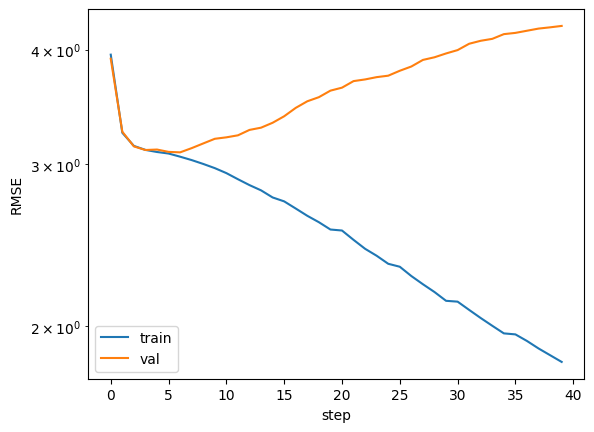

In [41]:
model4 = try_create_model(Model4, attributes, imgs_shape, kan_neurons, kan_grid)  # Attempt to create Model4
model_state, metrics4, best_epoch = fit_hybrid_dataloaders(model4, dataset, opt="LBFGS", steps=40, lamb=1e-05)
model4.load_state_dict(model_state)
print(average_rmse(model4(dataset['test_input'], dataset['test_img']), dataset['test_label']))
plt.plot(metrics4['train_loss'])
plt.plot(metrics4['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

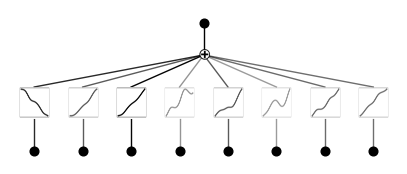

In [42]:
model4.m_kan.plot()

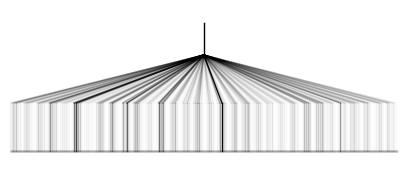

In [43]:
model4.final_kan.plot()

In [44]:
feature_score=model4.final_kan.feature_score

In [45]:
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=kan_neurons)

NameError: name 'plot_mkan_vs_cnn_relevance' is not defined

# Bonus Hybrid

In [ ]:
class Model5(nn.Module):
    def __init__(self, imgs_shape, kan_grid=kan_grid, device=device):
        super(Model5, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2, padding=1),
            nn.LayerNorm([16, 9, 9]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.LayerNorm([32, 5, 5]),
            nn.Sigmoid(),
            #nn.MaxPool2d(2),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, cnn_input):
        cnn_input = cnn_input.to(self.device)
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        
        #concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(cnn_output)

In [ ]:
def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        #old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_img"].shape[0]
    n_eval  = dataset["val_img"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            #mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            # model.final_kan.update_grid(mlp_batch)
            cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            # concatenated  = model.get_concat_output(cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(cnn_output)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                #mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                    if reg_metric == 'edge_backward':
                        #model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        #model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    # if sum_f_reg:
                    #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            #mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    #model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    #model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                # if sum_f_reg:
                #     reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from val_loader)
        #mlp_eval = dataset["val_input"][eval_indices]
        img_eval = dataset["val_img"][eval_indices]
        target_eval = dataset["val_label"][eval_indices]
        eval_loss = loss_fn(model(img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_input'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_label'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return results, best_model_state

In [ ]:
def try_create_model2(model_class, attributes, imgs_shape):
    try:
        model = model_class(imgs_shape)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [ ]:
model5 = try_create_model2(Model5, attributes, imgs_shape)  # Attempt to create Model4
metrics5, best_model_state = fit_hybrid_dataloaders2(model5, dataset, opt="LBFGS", steps=30, lamb=.00000001)
model5.load_state_dict(best_model_state)
print(average_rmse(model5(dataset['test_img']), dataset['test_label']))
plt.plot(metrics5['train_loss'])
plt.plot(metrics5['eval_loss'])
plt.legend(['train', 'val'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')